# NeuralForceField with AuTopology priors

#### Here we show how to run NeuralForceField with classical fixed priors, and also learnable classical priors based on AuTopology.

We start off with imports:

In [1]:
import sys
sys.path.append("../..")
sys.path.append("..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader


from nff.data import Dataset, split_train_validation_test
from nff.nn.modules import GraphDis
import pickle
from nff.data.loader import collate_dicts


from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
import json
import pdb
import copy


The dataset we use below was generated in `data/create_dataset_from_file` in the usual way, but with the additional call to the command `generate_topologies()`.

In [2]:
dataset = Dataset.from_file("data/autopology_demonstration.pth.tar")

For reasons that will become clear below, we'll also add some other props to our dataset. These props will be used when we train the AuTopology contribution to the gradient below in Section II.

In [3]:
dataset.props["auto_energy_0_grad"] = dataset.props["energy_0_grad"]
dataset.props["auto_energy_1_grad"] = dataset.props["energy_1_grad"]

Clean out any old work and split the data into testing and training:

In [4]:
DEVICE = 0
OUTDIR = './sandbox'
BATCH_SIZE = 25

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)


train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

Create the model by setting the SchNet readout dictionary, and some other parameters related to the model. Note that if `trainable_prior` is True then the constants in the classical priors are functions of the atomic environment and can be learned. Otherwise they are set to a reasonable default value and not learned.

In [5]:
n_atom_basis = 256

readoutdict = {
                    "energy_0": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}],
                    "energy_1": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}]
                }


params = {
    'n_atom_basis': n_atom_basis,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 10,
    'cutoff': 5.0,
    'trainable_gauss': True,
    'schnet_readout': readoutdict,    
    "sorted_result_keys": ["energy_0", "energy_1"],
    "grad_keys": ["energy_0_grad", "energy_1_grad"],
    "trainable_prior": True,
    "autopology_Lh": [40, 20],
    "bond_terms": ["morse"],
    "angle_terms": ["harmonic"],
    "dihedral_terms": ["OPLS"],
    "improper_terms": ["harmonic"],
    "pair_terms": ["LJ"],


}

model = get_model(params, model_type="SchNetAuTopology")




We now set the loss coefficients. We can either choose to evaluate the loss based only on how close the prediction is to the actual for `energy_0`, `energy_1`, and their gradients, or also based on how close the autopology results are to the actual answers. We'll look at each example separately, starting with training based only on the overall loss.

## I. Learnable AuTopology parameters, with a loss function for the combined SchNet + AuTopology result only

In [6]:
loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0}
loss_fn = loss.build_mse_loss(loss_coef=loss_coef)

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad')
]


train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

# mini_batches is the number of times you update the loss for a given batch before taking a 
# step in the training. Here we have 25 molecules per batch but 2 mini batches, meaning our loss
# is based on data from 2 x 25 = 50 molecules.

T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


Now train the model:

In [7]:
T.train(device=DEVICE, n_epochs=300)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-05 22:35:28 |     1 |     1.000e-04 | 12565.4180 |      12032.5764 |     149.8642 |           33.1122 |     130.9115 |           32.7033 |            7422
2019-11-05 22:35:29 |     2 |     1.000e-04 | 12377.9948 |      10410.7442 |     149.9872 |           32.8659 |     139.6275 |           32.5616 |            7422
2019-11-05 22:35:31 |     3 |     1.000e-04 | 11392.9728 |      10796.9004 |     153.9594 |           33.4075 |     147.3797 |           33.1272 |            7422
2019-11-05 22:35:33 |     4 |     1.000e-04 | 11129.6452 |       9918.5690 |     146.0035 |           32.4860 |     133.0620 |           32.1802 |            7422
2019-11-05 22:35:35 |     5 |     1.000e-04 | 10725.5535 |       9860.0570 |     142.3831 |           31.4003 |     126.2320 |           31.1354 |            7422
2019-11-05 22:35:36 | 

2019-11-05 22:36:51 |    51 |     1.000e-04 |  2075.7081 |       2071.9772 |      45.6946 |           16.7218 |      41.2476 |           16.6154 |            7422
2019-11-05 22:36:53 |    52 |     1.000e-04 |  1906.4808 |       2245.0029 |      45.9086 |           16.9700 |      48.6183 |           16.7689 |            7422
2019-11-05 22:36:55 |    53 |     1.000e-04 |  1873.0214 |       1987.7684 |      42.6201 |           16.5259 |      39.0062 |           16.5022 |            7422
2019-11-05 22:36:56 |    54 |     1.000e-04 |  1782.9766 |       1932.8162 |      48.7509 |           16.4581 |      42.8228 |           16.4791 |            7422
2019-11-05 22:36:58 |    55 |     1.000e-04 |  1784.6414 |       1907.2716 |      49.7670 |           16.4299 |      44.0969 |           16.4182 |            7422
2019-11-05 22:36:59 |    56 |     1.000e-04 |  1803.8526 |       1829.3337 |      41.0441 |           16.4546 |      38.0279 |           16.3887 |            7422
2019-11-05 22:37:01 | 

2019-11-05 22:38:13 |   102 |     1.000e-04 |   974.3545 |       1325.6339 |      25.7173 |           14.5005 |      30.5465 |           14.5468 |            7422
2019-11-05 22:38:14 |   103 |     1.000e-04 |   947.0353 |       1226.2209 |      23.7551 |           14.4835 |      27.9457 |           14.4241 |            7422
2019-11-05 22:38:16 |   104 |     1.000e-04 |   928.6985 |       1286.2594 |      30.6372 |           14.4062 |      29.2051 |           14.3751 |            7422
2019-11-05 22:38:17 |   105 |     1.000e-04 |   916.4646 |       1237.2259 |      25.4395 |           14.3427 |      25.6563 |           14.3544 |            7422
2019-11-05 22:38:19 |   106 |     1.000e-04 |   898.2401 |       1285.0911 |      24.8252 |           14.4216 |      29.5938 |           14.4286 |            7422
2019-11-05 22:38:20 |   107 |     1.000e-04 |   895.0627 |       1271.3504 |      25.8018 |           14.3086 |      26.7023 |           14.3149 |            7422
2019-11-05 22:38:22 | 

2019-11-05 22:39:33 |   153 |     1.000e-04 |   951.8751 |       1092.6561 |      25.4259 |           13.1234 |      23.3630 |           13.2642 |            7422
2019-11-05 22:39:35 |   154 |     1.000e-04 |   843.2371 |       1347.2336 |      44.7906 |           13.1987 |      43.8356 |           13.3717 |            7422
2019-11-05 22:39:36 |   155 |     1.000e-04 |   953.8384 |       1146.5288 |      24.5859 |           13.4182 |      26.3866 |           13.4239 |            7422
2019-11-05 22:39:38 |   156 |     1.000e-04 |   863.4636 |       1552.2144 |      42.4862 |           14.0122 |      45.0598 |           13.8772 |            7422
2019-11-05 22:39:39 |   157 |     1.000e-04 |   931.5155 |       1119.6095 |      22.7110 |           13.4034 |      25.2986 |           13.4061 |            7422
2019-11-05 22:39:41 |   158 |     1.000e-04 |   780.7860 |       1231.9010 |      38.3886 |           12.9140 |      37.2585 |           13.1630 |            7422
2019-11-05 22:39:43 | 

2019-11-05 22:40:54 |   204 |     1.000e-04 |   670.0376 |       1154.6200 |      21.9679 |           12.8093 |      28.0378 |           12.8488 |            7422
2019-11-05 22:40:55 |   205 |     1.000e-04 |   662.8337 |       1215.9962 |      26.6049 |           13.0149 |      30.6743 |           13.0512 |            7422
2019-11-05 22:40:57 |   206 |     1.000e-04 |   680.4405 |       1063.2453 |      22.2003 |           12.5208 |      22.0014 |           12.6802 |            7422
2019-11-05 22:40:58 |   207 |     1.000e-04 |   632.0117 |       1114.0219 |      32.2550 |           12.4576 |      30.4387 |           12.6532 |            7422
2019-11-05 22:41:00 |   208 |     1.000e-04 |   686.4209 |       1106.2788 |      27.1588 |           12.5763 |      25.9776 |           12.6693 |            7422
2019-11-05 22:41:01 |   209 |     1.000e-04 |   732.0636 |       1239.4544 |      28.2579 |           13.0338 |      32.9848 |           13.0138 |            7422
2019-11-05 22:41:03 | 

2019-11-05 22:42:14 |   255 |     5.000e-05 |   567.2838 |       1080.6529 |      20.9195 |           12.3245 |      23.9119 |           12.4525 |            7422
2019-11-05 22:42:15 |   256 |     5.000e-05 |   567.4851 |       1067.8237 |      21.9789 |           12.2797 |      22.6839 |           12.4016 |            7422
2019-11-05 22:42:17 |   257 |     5.000e-05 |   566.3485 |       1076.4177 |      20.9543 |           12.3184 |      23.5840 |           12.4475 |            7422
2019-11-05 22:42:19 |   258 |     5.000e-05 |   565.7069 |       1067.1562 |      21.4571 |           12.2951 |      22.8634 |           12.4175 |            7422
2019-11-05 22:42:20 |   259 |     5.000e-05 |   565.2289 |       1077.1011 |      20.7972 |           12.3182 |      23.6584 |           12.4483 |            7422
2019-11-05 22:42:22 |   260 |     5.000e-05 |   565.8082 |       1069.4048 |      21.2817 |           12.2927 |      23.0817 |           12.4195 |            7422
2019-11-05 22:42:23 | 

Now we'll evaluate the results:

In [8]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)

We'll want to compare many different targets and results, so we'll define a function `plot_overall` that plots energies and gradients vs. targets, and a function `plot_autopology`, that compares only the AuTopology part of the gradients to the actual gradients.

In [9]:
def make_plot(key_pairs, results, targets, target_dic=None):
    
    all_keys = np.array(key_pairs).reshape(-1)
    units = dict()
    for key in all_keys:
        if "grad" in key:
            units[key] = r'kcal/mol/$\AA$'
        else:
            units[key] = 'kcal/mol'

    if target_dic is None:
        target_dic = {key: key for key in all_keys}

    for i in range(len(key_pairs)):

        fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

        for ax, key in zip(ax_fig, key_pairs[i]):

            pred = (results[key]).reshape(-1).cpu().detach().numpy()
            target_key = target_dic[key]
            targ = (targets[target_key]).reshape(-1).cpu().detach().numpy()

            ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)

            mae = np.mean(abs(pred-targ))
            if "grad" in key:
                these_units = r"kcal/mol/$\AA$"
            else:
                these_units = r"kcal/mol"
            plt.text(0.1, 0.75, "MAE = {} {}".format(str(round(mae, 1)), these_units),
                     transform=ax.transAxes, fontsize=14)

            lim_min = min(np.min(pred), np.min(targ)) * 1.1
            lim_max = max(np.max(pred), np.max(targ)) * 1.1

            ax.set_xlim(lim_min, lim_max)
            ax.set_ylim(lim_min, lim_max)
            ax.set_aspect('equal')

            ax.plot((lim_min, lim_max),
                    (lim_min, lim_max),
                    color='#000000',
                    zorder=-1,
                    linewidth=0.5)

            ax.set_title(key.upper(), fontsize=14)
            ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
            ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)


def plot_overall(results, targets):
    key_pairs = [["energy_0", "energy_0_grad"], ["energy_1", "energy_1_grad"]]
    make_plot(key_pairs, results, targets)

def plot_autopology(results, targets):
    key_pairs = [["auto_energy_0_grad", "auto_energy_1_grad"]]
    target_dic = {"auto_energy_0_grad": "energy_0_grad", "auto_energy_1_grad": "energy_1_grad"}
    make_plot(key_pairs, results, targets, target_dic)

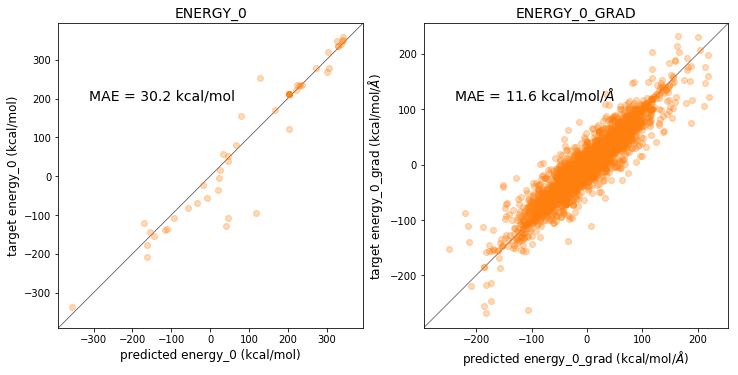

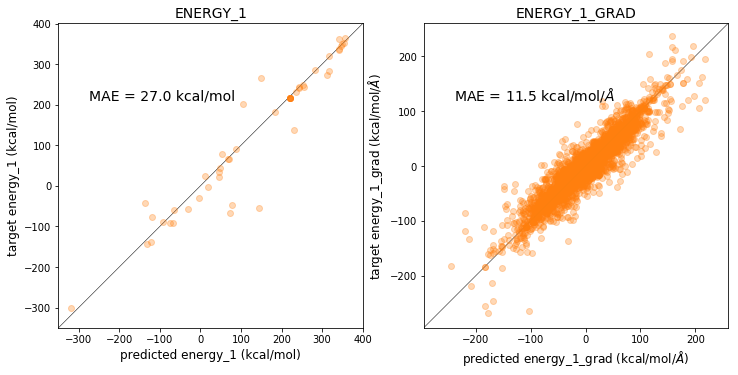

In [10]:
plot_overall(results, targets)

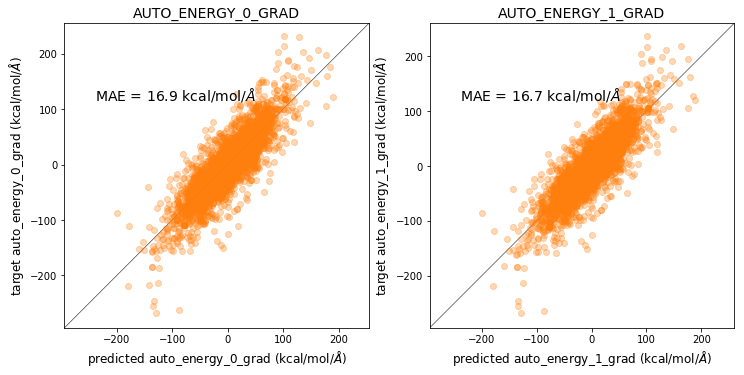

In [11]:
plot_autopology(results, targets)

Interestingly, the AuTopology gradient results are accurate to about 17 kcal/mol/A, and the remaining 5 kcal/mol/A corrections come from the SchNet component. This is what we want: AuTopology get the answer broadly correct, and SchNet does the rest of the corrections.

## II. Learnable AuTopology parameters, with a loss function for the combined SchNet + AuTopology result *and* for the AuTopology part of the result

Now let's try also training on the AuTopology forces directly

In [15]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)



In [16]:
new_model = get_model(params, model_type="SchNetAuTopology")
new_loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0,
            'auto_energy_0_grad': 0.05, 'auto_energy_1_grad': 0.05}

new_loss_fn = loss.build_mse_loss(loss_coef=new_loss_coef)
trainable_params = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad')
]


train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

new_T = Trainer(
        model_path=OUTDIR,
        model=new_model,
        loss_fn=new_loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )

In [17]:
new_T.train(device=DEVICE, n_epochs=300)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-05 22:50:22 |     1 |     1.000e-04 | 14347.4510 |      11925.5701 |     148.3871 |           36.0576 |     130.9281 |           35.9147 |            8961
2019-11-05 22:50:23 |     2 |     1.000e-04 | 12545.7513 |      10858.1051 |     151.5049 |           33.7229 |     137.9715 |           33.4875 |            8961
2019-11-05 22:50:25 |     3 |     1.000e-04 | 11874.1077 |      11029.2071 |     151.5660 |           33.7011 |     142.0342 |           33.4268 |            8961
2019-11-05 22:50:27 |     4 |     1.000e-04 | 11515.3465 |      10437.1706 |     146.8187 |           33.1560 |     133.9175 |           32.9526 |            8961
2019-11-05 22:50:29 |     5 |     1.000e-04 | 10989.2658 |      10245.2761 |     139.7326 |           32.7397 |     125.2941 |           32.6150 |            8961
2019-11-05 22:50:31 | 

2019-11-05 22:51:52 |    51 |     1.000e-04 |  2003.1585 |       2120.2179 |      39.4752 |           17.3129 |      37.1033 |           17.1038 |            8961
2019-11-05 22:51:54 |    52 |     1.000e-04 |  1873.7416 |       1964.0888 |      43.3747 |           17.0769 |      39.2154 |           16.7146 |            8961
2019-11-05 22:51:56 |    53 |     1.000e-04 |  1864.4794 |       1894.2761 |      32.7524 |           17.4595 |      34.0371 |           16.8568 |            8961
2019-11-05 22:51:58 |    54 |     1.000e-04 |  1781.2756 |       2146.3317 |      39.6699 |           17.7528 |      45.9010 |           17.1989 |            8961
2019-11-05 22:51:59 |    55 |     1.000e-04 |  1765.9655 |       1915.4775 |      35.0165 |           16.9836 |      33.2759 |           16.7261 |            8961
2019-11-05 22:52:01 |    56 |     1.000e-04 |  1697.0218 |       1820.4688 |      39.7639 |           16.4505 |      36.9052 |           16.2796 |            8961
2019-11-05 22:52:03 | 

2019-11-05 22:53:23 |   102 |     1.000e-04 |  1268.4554 |       1484.5620 |      26.2494 |           15.0632 |      30.9596 |           14.8586 |            8961
2019-11-05 22:53:24 |   103 |     1.000e-04 |  1171.4183 |       1479.8992 |      36.1792 |           14.6467 |      35.3293 |           14.6783 |            8961
2019-11-05 22:53:26 |   104 |     1.000e-04 |  1181.1804 |       1394.9668 |      27.7506 |           14.7609 |      25.9767 |           14.5578 |            8961
2019-11-05 22:53:28 |   105 |     1.000e-04 |  1125.8101 |       1713.7580 |      38.7147 |           15.5751 |      42.5431 |           15.2874 |            8961
2019-11-05 22:53:30 |   106 |     1.000e-04 |  1188.0519 |       1439.7561 |      24.6261 |           14.9143 |      28.6417 |           14.6907 |            8961
2019-11-05 22:53:32 |   107 |     1.000e-04 |  1100.4074 |       1442.2826 |      33.3888 |           14.6498 |      32.4926 |           14.6391 |            8961
2019-11-05 22:53:33 | 

2019-11-05 22:54:52 |   153 |     1.000e-04 |   957.1615 |       1348.6887 |      29.1063 |           13.8712 |      26.9347 |           13.8248 |            8961
2019-11-05 22:54:54 |   154 |     1.000e-04 |   919.7862 |       1360.0578 |      30.8102 |           13.7898 |      29.2654 |           13.7165 |            8961
2019-11-05 22:54:56 |   155 |     1.000e-04 |   953.6476 |       1418.3454 |      24.0652 |           14.2977 |      30.4477 |           14.0614 |            8961
2019-11-05 22:54:57 |   156 |     1.000e-04 |   945.9566 |       1573.0661 |      33.6783 |           14.4040 |      37.7381 |           14.1262 |            8961
2019-11-05 22:54:59 |   157 |     1.000e-04 |   968.2472 |       1369.3396 |      26.2207 |           13.9032 |      24.3691 |           13.8321 |            8961
2019-11-05 22:55:01 |   158 |     1.000e-04 |   919.9111 |       1364.3490 |      32.1446 |           13.7420 |      30.7196 |           13.6936 |            8961
2019-11-05 22:55:03 | 

2019-11-05 22:56:20 |   204 |     1.000e-04 |   857.7342 |       1328.0357 |      30.1464 |           13.3627 |      28.8368 |           13.3130 |            8961
2019-11-05 22:56:21 |   205 |     1.000e-04 |   887.7648 |       1470.7533 |      27.8920 |           14.0776 |      33.7831 |           13.8710 |            8961
2019-11-05 22:56:23 |   206 |     1.000e-04 |   893.1805 |       1555.8731 |      33.3575 |           13.9821 |      37.6459 |           13.7457 |            8961
2019-11-05 22:56:25 |   207 |     1.000e-04 |   908.3652 |       1308.5757 |      28.4722 |           13.3882 |      26.5610 |           13.2969 |            8961
2019-11-05 22:56:27 |   208 |     1.000e-04 |   850.0512 |       1332.3923 |      32.2899 |           13.3030 |      31.1759 |           13.2704 |            8961
2019-11-05 22:56:29 |   209 |     1.000e-04 |   889.4226 |       1408.7110 |      23.3210 |           13.9109 |      29.8887 |           13.7427 |            8961
2019-11-05 22:56:30 | 

2019-11-05 22:57:47 |   255 |     1.000e-04 |   808.2362 |       1314.4148 |      28.3533 |           13.1446 |      27.0975 |           13.0893 |            8961
2019-11-05 22:57:49 |   256 |     1.000e-04 |   813.5432 |       1521.2122 |      30.3016 |           13.8801 |      35.5722 |           13.7430 |            8961
2019-11-05 22:57:50 |   257 |     1.000e-04 |   856.2260 |       1394.0958 |      24.4031 |           13.5722 |      29.7712 |           13.4056 |            8961
2019-11-05 22:57:52 |   258 |     1.000e-04 |   823.7032 |       1293.9541 |      30.4554 |           13.0699 |      29.8189 |           12.9609 |            8961
2019-11-05 22:57:54 |   259 |     1.000e-04 |   811.2607 |       1320.9537 |      27.5744 |           13.1665 |      26.2964 |           13.1129 |            8961
2019-11-05 22:57:55 |   260 |     1.000e-04 |   812.1998 |       1538.2596 |      31.3094 |           13.9303 |      36.3077 |           13.7834 |            8961
2019-11-05 22:57:57 | 

In [18]:
new_results, new_targets, new_val_loss = evaluate(new_model, test_loader, new_loss_fn, device=DEVICE)

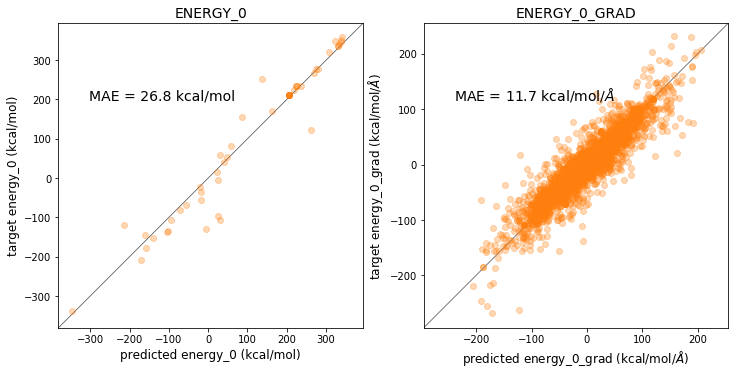

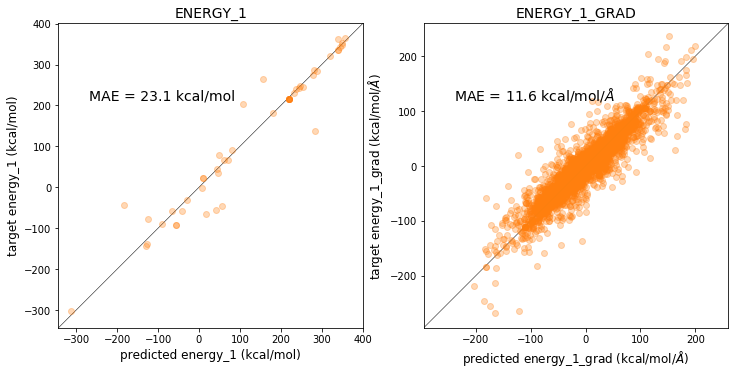

In [19]:
plot_overall(new_results, new_targets)

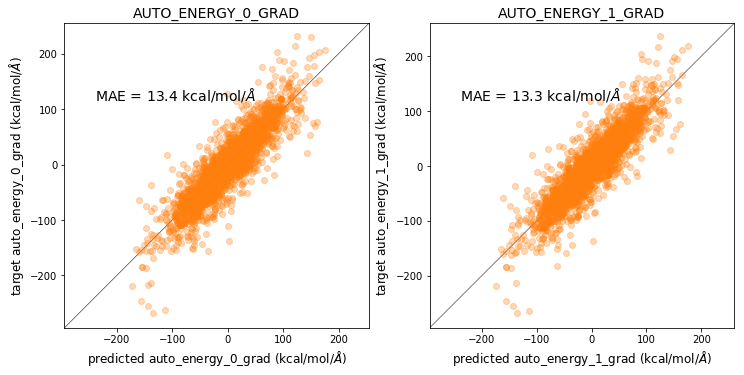

In [20]:
plot_autopology(new_results, new_targets)

The overall results are pretty similar to case I, while the AuTopology gradients agree with the actual gradients better. The energies are somewhat more accurate here, but it's difficult to tell with such a small dataset.

## III. Non-learnable AuTopology parameters

Lastly we set the AuTopology parameters to fixed, non-learnable parameters. Of the possible bond terms, only the harmonic option has a default non-zero value to which corrections are added. So we change the bond term from Morse to harmonic and set `trainable_prior` to False. Everything else is the same.

Note that the dihedral and improper terms also do not have default non-zero values.

In [21]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)



final_params = copy.copy(params)
final_params.update({"trainable_prior": False, 'bond_terms': ['harmonic']})

final_model = get_model(final_params, model_type="SchNetAuTopology")
final_loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0}

final_loss_fn = loss.build_mse_loss(loss_coef=final_loss_coef)
trainable_params = filter(lambda p: p.requires_grad, final_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad')
]


train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

final_T = Trainer(
        model_path=OUTDIR,
        model=final_model,
        loss_fn=final_loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )



In [22]:
final_T.train(device=DEVICE, n_epochs=300)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-05 23:00:30 |     1 |     1.000e-04 | 12657.0527 |      11464.7829 |     159.2880 |           36.4230 |     144.5445 |           36.3255 |            8961
2019-11-05 23:00:32 |     2 |     1.000e-04 | 12054.8799 |      11071.3299 |     156.7569 |           36.2728 |     142.1719 |           36.1523 |            8961
2019-11-05 23:00:33 |     3 |     1.000e-04 | 11767.5666 |      10929.9334 |     155.5035 |           36.0789 |     141.1529 |           35.9653 |            8961
2019-11-05 23:00:34 |     4 |     1.000e-04 | 11499.5417 |      10850.6870 |     154.3600 |           35.8276 |     140.4924 |           35.7309 |            8961
2019-11-05 23:00:36 |     5 |     1.000e-04 | 11243.8159 |      10665.9587 |     152.2229 |           35.4862 |     138.9619 |           35.4233 |            8961
2019-11-05 23:00:37 | 

2019-11-05 23:01:34 |    51 |     1.000e-04 |  1965.8939 |       2335.3299 |      59.2302 |           18.3567 |      57.1230 |           17.9898 |            8961
2019-11-05 23:01:36 |    52 |     1.000e-04 |  2524.2592 |       2282.9153 |      57.4380 |           18.2089 |      56.2492 |           17.8746 |            8961
2019-11-05 23:01:37 |    53 |     1.000e-04 |  2617.2587 |       2584.8842 |      59.4603 |           18.1599 |      58.0636 |           17.7559 |            8961
2019-11-05 23:01:38 |    54 |     1.000e-04 |  2143.2400 |       1931.3085 |      41.3886 |           18.2277 |      41.2458 |           17.8174 |            8961
2019-11-05 23:01:40 |    55 |     1.000e-04 |  1815.7174 |       1974.9193 |      47.6474 |           18.6325 |      47.2958 |           18.0772 |            8961
2019-11-05 23:01:41 |    56 |     1.000e-04 |  2001.7831 |       1931.9538 |      37.0394 |           18.3015 |      39.8909 |           17.8644 |            8961
2019-11-05 23:01:42 | 

2019-11-05 23:02:40 |   102 |     1.000e-04 |  1380.4731 |       1802.0139 |      52.9726 |           15.2871 |      52.4896 |           14.9237 |            8961
2019-11-05 23:02:41 |   103 |     1.000e-04 |  1410.4805 |       1411.4185 |      34.9285 |           14.9186 |      36.9921 |           14.7068 |            8961
2019-11-05 23:02:42 |   104 |     1.000e-04 |  1220.8946 |       1466.6706 |      46.0464 |           14.8536 |      45.5663 |           14.7587 |            8961
2019-11-05 23:02:44 |   105 |     1.000e-04 |  1297.1545 |       1201.0507 |      29.7556 |           14.7828 |      28.9028 |           14.7162 |            8961
2019-11-05 23:02:45 |   106 |     1.000e-04 |  1144.3358 |       1429.2360 |      38.1476 |           15.0307 |      40.1747 |           14.8543 |            8961
2019-11-05 23:02:46 |   107 |     1.000e-04 |  1164.8024 |       1201.4466 |      25.2299 |           14.6877 |      27.9835 |           14.5065 |            8961
2019-11-05 23:02:47 | 

2019-11-05 23:03:44 |   153 |     1.000e-04 |   899.2325 |       1032.6383 |      23.8724 |           13.0415 |      26.9407 |           13.0382 |            8961
2019-11-05 23:03:46 |   154 |     1.000e-04 |   874.7501 |       1019.2127 |      31.3601 |           13.0818 |      31.1148 |           12.9987 |            8961
2019-11-05 23:03:47 |   155 |     1.000e-04 |   870.4573 |       1115.0135 |      35.1682 |           13.3008 |      35.7578 |           13.1398 |            8961
2019-11-05 23:03:48 |   156 |     1.000e-04 |   961.0785 |       1015.8515 |      22.9691 |           13.3784 |      25.2699 |           13.1755 |            8961
2019-11-05 23:03:49 |   157 |     1.000e-04 |   963.6106 |       1291.3913 |      40.9369 |           13.2940 |      42.3560 |           13.1346 |            8961
2019-11-05 23:03:51 |   158 |     1.000e-04 |   987.6110 |       1280.9201 |      40.0663 |           13.1090 |      40.5542 |           13.0808 |            8961
2019-11-05 23:03:52 | 

2019-11-05 23:04:48 |   204 |     1.000e-04 |   736.0586 |        952.2792 |      32.4392 |           12.1836 |      32.7577 |           12.1037 |            8961
2019-11-05 23:04:49 |   205 |     1.000e-04 |   759.0292 |        958.2420 |      25.0717 |           12.5737 |      28.4987 |           12.4349 |            8961
2019-11-05 23:04:51 |   206 |     1.000e-04 |   764.9392 |       1074.5784 |      35.5344 |           12.2837 |      36.8259 |           12.2333 |            8961
2019-11-05 23:04:52 |   207 |     1.000e-04 |   777.9809 |        904.9668 |      27.3918 |           12.0488 |      27.4349 |           12.1170 |            8961
2019-11-05 23:04:53 |   208 |     1.000e-04 |   707.4278 |        931.1121 |      30.3528 |           12.1412 |      30.8693 |           12.0880 |            8961
2019-11-05 23:04:54 |   209 |     1.000e-04 |   729.8894 |        921.4967 |      21.5494 |           12.4662 |      25.2470 |           12.3510 |            8961
2019-11-05 23:04:56 | 

2019-11-05 23:05:53 |   255 |     1.000e-04 |   620.6335 |        908.0359 |      26.6154 |           11.6178 |      29.1379 |           11.5692 |            8961
2019-11-05 23:05:54 |   256 |     1.000e-04 |   631.6039 |        901.8096 |      26.1429 |           11.4995 |      28.3868 |           11.5111 |            8961
2019-11-05 23:05:55 |   257 |     1.000e-04 |   649.1254 |        800.6490 |      21.8156 |           11.4154 |      22.5175 |           11.4341 |            8961
2019-11-05 23:05:57 |   258 |     1.000e-04 |   619.3187 |        899.4705 |      30.7248 |           11.5588 |      31.3119 |           11.4701 |            8961
2019-11-05 23:05:58 |   259 |     1.000e-04 |   670.3185 |        894.8651 |      25.9368 |           11.6987 |      27.1589 |           11.6016 |            8961
2019-11-05 23:05:59 |   260 |     1.000e-04 |   746.4690 |        941.9457 |      27.7518 |           11.6579 |      30.7381 |           11.5825 |            8961
2019-11-05 23:06:01 | 

In [23]:
final_results, final_targets, final_val_loss = evaluate(final_model, test_loader, final_loss_fn, device=DEVICE)

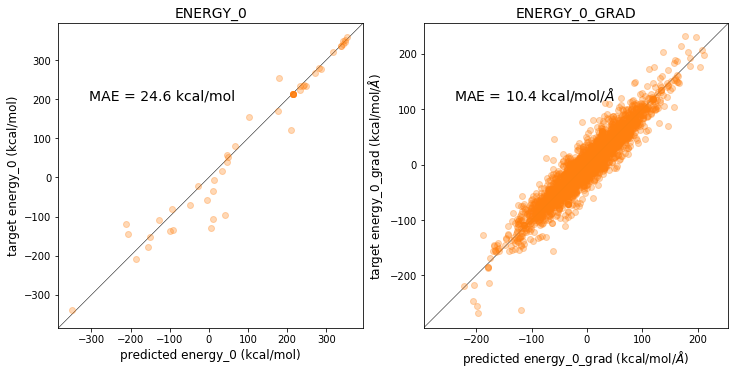

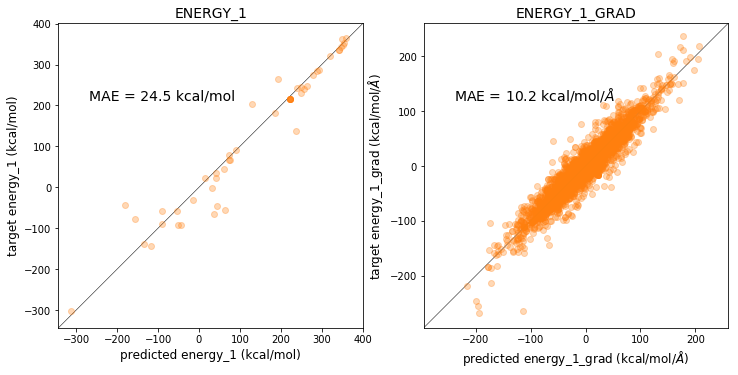

In [24]:
plot_overall(final_results, final_targets)

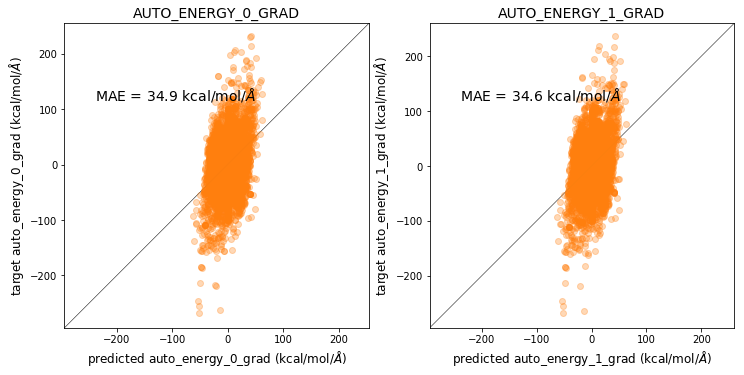

In [25]:
plot_autopology(final_results, final_targets)

When the AuTopology parameters aren't learnable, there is only a weak correlation between the autopology part of the gradients and the overall gradients, as expected. If we don't treat them as trainable then they're just there to make sure our molecules don't explode during MD simulations.

The overall results without learnable AuTopology parameters are slightly better than the other two cases, but fairly similar.